# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [120]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DateType, TimestampType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import functions as F, window
import datetime
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn import metrics

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot
from itertools import chain

# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 60
pd.set_option('display.max_columns', 300)

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project Session") \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.driver.host', 'a4e20d4126f3'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '46281'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1606687690066'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'Sparkify Project Session')]

In [4]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Load Dataset

In [5]:
#load json
path = "mini_sparkify_event_data.json"
event_data = spark.read.json(path)

In [6]:
event_data.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [7]:
event_data.count()

286500

In [89]:
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## Clean Dataset

In [9]:
event_data=event_data.drop_duplicates()

In [10]:
event_data.count()

286500

In [11]:
#count if there are null entries
event_data.select([F.count(F.when(F.col(column).isNull(), F.col(column))).alias(column) for column in event_data.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [12]:
#filter out records without userids
event_data=event_data.filter(F.col('userId')!='')

In [13]:
event_data.count()

278154

In [14]:
#filter out records without sessionids.
event_data=event_data.filter(F.col('sessionId')>0)

In [15]:
event_data.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Let's explore the data a little bit before defining churn...

In [16]:
event_data.describe().show()

+-------+------------------+---------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|     auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+---------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|   278154|   278154|278154|            278154|  278154|           228108|278154|           278154|278154| 278154|          

In [17]:
event_data.take(2)

[Row(artist='The Futureheads', auth='Logged In', firstName='Ainsley', gender='F', itemInSession=80, lastName='Farley', length=120.81587, level='free', location='McAllen-Edinburg-Mission, TX', method='PUT', page='NextSong', registration=1538304455000, sessionId=187, song='Robot', status=200, ts=1538373133000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"', userId='78'),
 Row(artist=None, auth='Logged In', firstName='Ainsley', gender='F', itemInSession=81, lastName='Farley', length=None, level='free', location='McAllen-Edinburg-Mission, TX', method='PUT', page='Thumbs Down', registration=1538304455000, sessionId=187, song=None, status=307, ts=1538373134000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"', userId='78')]

In [18]:
#create a view and run sql queries
event_data.createOrReplaceTempView("event_data_table")

In [112]:
#how many distinct userId s
spark.sql("SELECT count(1) from (SELECT distinct userId FROM event_data_table)").show()

+--------+
|count(1)|
+--------+
|     225|
+--------+



In [113]:
spark.sql("SELECT * FROM event_data_table LIMIT 2").show()

+---------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+-----+------+-------------+--------------------+------+
|         artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|       page| registration|sessionId| song|status|           ts|           userAgent|userId|
+---------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+-----+------+-------------+--------------------+------+
|The Futureheads|Logged In|  Ainsley|     F|           80|  Farley|120.81587| free|McAllen-Edinburg-...|   PUT|   NextSong|1538304455000|      187|Robot|   200|1538373133000|"Mozilla/5.0 (Win...|    78|
|           null|Logged In|  Ainsley|     F|           81|  Farley|     null| free|McAllen-Edinburg-...|   PUT|Thumbs Down|1538304455000|      187| null|   307|1538373134000|"Mozilla/5.0 (

In [34]:
def count_group_in_table(columns, tablename, n=10):
    spark.sql("Select " + columns +", count(1) from " + tablename + " group by " + columns + " order by count(1) desc" ).show(n)

In [35]:
#top interactions per user id
count_group_in_table("userId", "event_data_table")

+------+--------+
|userId|count(1)|
+------+--------+
|    39|    9632|
|    92|    7230|
|   140|    6880|
|300011|    5732|
|   124|    4825|
|300021|    4659|
|300017|    4428|
|    85|    4370|
|    42|    4257|
|200023|    3769|
+------+--------+
only showing top 10 rows



In [25]:
#location distributions
count_group_in_table("location", "event_data_table")

+--------------------+--------+
|            location|count(1)|
+--------------------+--------+
|Los Angeles-Long ...|   30131|
|New York-Newark-J...|   23684|
|Boston-Cambridge-...|   13873|
|Houston-The Woodl...|    9499|
|Charlotte-Concord...|    7780|
|Dallas-Fort Worth...|    7605|
|Louisville/Jeffer...|    6880|
|Philadelphia-Camd...|    5890|
|Chicago-Napervill...|    5114|
|    St. Louis, MO-IL|    4858|
+--------------------+--------+
only showing top 10 rows



In [26]:
#distinct authorization types
count_group_in_table("auth", "event_data_table")

+---------+--------+
|     auth|count(1)|
+---------+--------+
|Logged In|  278102|
|Cancelled|      52|
+---------+--------+



In [27]:
#methods
count_group_in_table("method", "event_data_table")

+------+--------+
|method|count(1)|
+------+--------+
|   PUT|  257818|
|   GET|   20336|
+------+--------+



In [28]:
#gender distributions
count_group_in_table("gender", "event_data_table")

+------+--------+
|gender|count(1)|
+------+--------+
|     F|  154578|
|     M|  123576|
+------+--------+



In [29]:
#gender distributions, why null?
count_group_in_table("gender, auth", "event_data_table")

+------+---------+--------+
|gender|     auth|count(1)|
+------+---------+--------+
|     F|Logged In|  154558|
|     M|Logged In|  123544|
|     M|Cancelled|      32|
|     F|Cancelled|      20|
+------+---------+--------+



In [30]:
#status distributions
count_group_in_table("status", "event_data_table")

+------+--------+
|status|count(1)|
+------+--------+
|   200|  254718|
|   307|   23184|
|   404|     252|
+------+--------+



In [31]:
#userAgent distributions
count_group_in_table("userAgent", "event_data_table")

+--------------------+--------+
|           userAgent|count(1)|
+--------------------+--------+
|"Mozilla/5.0 (Win...|   22751|
|"Mozilla/5.0 (Mac...|   19611|
|"Mozilla/5.0 (Mac...|   18448|
|"Mozilla/5.0 (Mac...|   17348|
|Mozilla/5.0 (Wind...|   16700|
|"Mozilla/5.0 (Win...|   15395|
|"Mozilla/5.0 (Win...|   14598|
|Mozilla/5.0 (Maci...|   10300|
|"Mozilla/5.0 (iPa...|    8912|
|Mozilla/5.0 (comp...|    8624|
+--------------------+--------+
only showing top 10 rows



In [32]:
#time range
spark.sql("SELECT from_unixtime(floor(max(ts)/1000)), from_unixtime(floor(min(ts)/1000)) from event_data_table").show(10,False)

+-------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+
|from_unixtime(FLOOR((CAST(max(ts) AS DOUBLE) / CAST(1000 AS DOUBLE))), yyyy-MM-dd HH:mm:ss)|from_unixtime(FLOOR((CAST(min(ts) AS DOUBLE) / CAST(1000 AS DOUBLE))), yyyy-MM-dd HH:mm:ss)|
+-------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+
|2018-12-03 01:11:16                                                                        |2018-10-01 00:01:57                                                                        |
+-------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+



In [36]:
#page distributions
count_group_in_table("page", "event_data_table", 50)

+--------------------+--------+
|                page|count(1)|
+--------------------+--------+
|            NextSong|  228108|
|           Thumbs Up|   12551|
|                Home|   10082|
|     Add to Playlist|    6526|
|          Add Friend|    4277|
|         Roll Advert|    3933|
|              Logout|    3226|
|         Thumbs Down|    2546|
|           Downgrade|    2055|
|            Settings|    1514|
|                Help|    1454|
|             Upgrade|     499|
|               About|     495|
|       Save Settings|     310|
|               Error|     252|
|      Submit Upgrade|     159|
|    Submit Downgrade|      63|
|              Cancel|      52|
|Cancellation Conf...|      52|
+--------------------+--------+



### Churn Definition

There were 52 "Cancellation Confirmation" pages and 52 latest auth status as "Cancelled" found above, which will be marked as Churn.

In [37]:
event_data.filter("page = 'Cancellation Confirmation'").show(52)

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|     Mahi|     F|           17| Robinson|  null| free|Houston-The Woodl...|   GET|Cancellation Conf...|1537898335000|      191|null|   200|1542038645000|Mozilla/5.0 (Maci...|100022|
|  null|Cancelled|   Keegan|     M|           46|   Rivera|  null| free|Orlando-Kissimmee...|   GET|Cancellation Conf...|1535907116000|      351|null|   200|1542472842000|Mozilla/5.0 (Maci...|200020|


In [38]:
#find out the last status of each userId
#collect out tenure, device, gender, location, etc per each user (at the time of their last interaction, assuming that these did not change)
#define churn for each user
last_status = spark.sql("select userId, min(ts) as min_ts, max(ts) as max_ts, max(ts)-min(ts) as tenure from event_data_table group by userId")
last_status.createOrReplaceTempView("last_status_table")

last_user_state = spark.sql(" \
SELECT t1.userId, t1.tenure, t1.min_ts, t1.max_ts,  \
case when t2.Auth = 'Cancelled' then 1 else 0 end as Churn, \
t2.firstName, t2.lastName, t2.location, t2.gender, t2.level, t2.location, t2.registration, t2.userAgent  \
from last_status_table t1 \
inner join event_data_table t2 \
on t1.userId=t2.userId and t1.max_ts=t2.ts")

In [126]:
last_user_state.head(2)

[Row(userId='200008', tenure=4940593000, min_ts=1538681986000, max_ts=1543622579000, Churn=0, firstName='Adriana', lastName='Mayer', location='Charlotte-Concord-Gastonia, NC-SC', gender='F', level='paid', location='Charlotte-Concord-Gastonia, NC-SC', registration=1533670697000, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userId='96', tenure=5024639000, min_ts=1538513240000, max_ts=1543537879000, Churn=0, firstName='Alexandria', lastName='Mills', location='Atlantic City-Hammonton, NJ', gender='F', level='paid', location='Atlantic City-Hammonton, NJ', registration=1537149749000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"')]

In [39]:
spark.catalog.dropTempView("last_status_table")
del last_status

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Calculate number of interactions (pages) per each userId during their customer journey

In order to asses how the user interacted with the app, calculate features that measure interactions (either negative or positive pages)

Calculate features that measure song interactions & sessions, etc

Add other possible columns that can be useful

In [40]:
#state name
last_user_state = last_user_state.withColumn("state_abbr", last_user_state.location.substr(-2,2))

In [41]:
#device type from browser/app info
last_user_state = last_user_state.withColumn(
    "device",
    F.regexp_extract(last_user_state.userAgent, r"(\([a-zA-Z0-9]+[ ;])", 0))

last_user_state=last_user_state.withColumn("device_clean",F.regexp_extract(last_user_state.device, r"([a-zA-Z0-9]+)", 0))

In [42]:
last_user_state.printSchema

<bound method DataFrame.printSchema of DataFrame[userId: string, tenure: bigint, min_ts: bigint, max_ts: bigint, Churn: int, firstName: string, lastName: string, location: string, gender: string, level: string, location: string, registration: bigint, userAgent: string, state_abbr: string, device: string, device_clean: string]>

In [43]:
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [44]:
#partition by user
wf_user = window.Window().partitionBy('userId')

In [45]:
feature_list = event_data\
.withColumn('f_total_interactions',F.count('*').over(wf_user))\
.withColumn('f_artist_count', F.size(F.collect_set(F.col('artist')).over(wf_user)))\
.withColumn('f_song_count', F.size(F.collect_set(F.col('song')).over(wf_user)))\
.withColumn('f_session_count', F.size(F.collect_set(F.col('sessionId')).over(wf_user)))\
.withColumn('p_homepage_lands', F.sum(F.when(F.col('page')=='Home',1).otherwise(0)).over(wf_user))\
.withColumn('p_nextsongs', F.sum(F.when(F.col('page')=='NextSong',1).otherwise(0)).over(wf_user))\
.withColumn('p_thumbsup', F.sum(F.when(F.col('page')=='Thumbs Up',1).otherwise(0)).over(wf_user))\
.withColumn('p_thumbsdown', F.sum(F.when(F.col('page')=='Thumbs Down',1).otherwise(0)).over(wf_user))\
.withColumn('p_addtoplaylist', F.sum(F.when(F.col('page')=='Add to Playlist',1).otherwise(0)).over(wf_user))\
.withColumn('p_addfriend', F.sum(F.when(F.col('page')=='Add Friend',1).otherwise(0)).over(wf_user))\
.withColumn('p_rolladvert', F.sum(F.when(F.col('page')=='Roll Advert',1).otherwise(0)).over(wf_user))\
.withColumn('p_logout', F.sum(F.when(F.col('page')=='Logout',1).otherwise(0)).over(wf_user))\
.withColumn('p_downgrade', F.sum(F.when(F.col('page')=='Downgrade',1).otherwise(0)).over(wf_user))\
.withColumn('p_settings', F.sum(F.when(F.col('page')=='Settings',1).otherwise(0)).over(wf_user))\
.withColumn('p_help', F.sum(F.when(F.col('page')=='Help',1).otherwise(0)).over(wf_user))\
.withColumn('p_upgrade', F.sum(F.when(F.col('page')=='Upgrade',1).otherwise(0)).over(wf_user))\
.withColumn('p_about', F.sum(F.when(F.col('page')=='About',1).otherwise(0)).over(wf_user))\
.withColumn('p_savesettings', F.sum(F.when(F.col('page')=='Save Settings',1).otherwise(0)).over(wf_user))\
.withColumn('p_error', F.sum(F.when(F.col('page')=='Error',1).otherwise(0)).over(wf_user))\
.withColumn('p_submitupgrade', F.sum(F.when(F.col('page')=='Submit Upgrade',1).otherwise(0)).over(wf_user))\
.withColumn('p_submitdowngrade', F.sum(F.when(F.col('page')=='Submit Downgrade',1).otherwise(0)).over(wf_user))\
.withColumn('v_http307', F.sum(F.when(F.col('status')==307,1).otherwise(0)).over(wf_user))\
.withColumn('v_http400', F.sum(F.when(F.col('status')==400,1).otherwise(0)).over(wf_user))\
.withColumn('v_methodput', F.sum(F.when(F.col('method')=='PUT',1).otherwise(0)).over(wf_user))\
.withColumn('v_methodget', F.sum(F.when(F.col('method')=='GET',1).otherwise(0)).over(wf_user))\
.select(*['userId', 'f_total_interactions','f_artist_count','f_song_count','f_session_count', 'p_homepage_lands', 'p_nextsongs', 'p_thumbsup', 'p_thumbsdown','p_addtoplaylist', 'p_addfriend', 'p_rolladvert','p_logout', 'p_downgrade', 'p_settings', 'p_help', 'p_upgrade', 'p_about', 'p_savesettings', 'p_error', 'p_submitupgrade', 'p_submitdowngrade', 'v_http307', 'v_http400', 'v_methodput', 'v_methodget'])\
.distinct()

In [46]:
feature_list.printSchema()

root
 |-- userId: string (nullable = true)
 |-- f_total_interactions: long (nullable = false)
 |-- f_artist_count: integer (nullable = false)
 |-- f_song_count: integer (nullable = false)
 |-- f_session_count: integer (nullable = false)
 |-- p_homepage_lands: long (nullable = true)
 |-- p_nextsongs: long (nullable = true)
 |-- p_thumbsup: long (nullable = true)
 |-- p_thumbsdown: long (nullable = true)
 |-- p_addtoplaylist: long (nullable = true)
 |-- p_addfriend: long (nullable = true)
 |-- p_rolladvert: long (nullable = true)
 |-- p_logout: long (nullable = true)
 |-- p_downgrade: long (nullable = true)
 |-- p_settings: long (nullable = true)
 |-- p_help: long (nullable = true)
 |-- p_upgrade: long (nullable = true)
 |-- p_about: long (nullable = true)
 |-- p_savesettings: long (nullable = true)
 |-- p_error: long (nullable = true)
 |-- p_submitupgrade: long (nullable = true)
 |-- p_submitdowngrade: long (nullable = true)
 |-- v_http307: long (nullable = true)
 |-- v_http400: long (n

In [47]:
feature_list.head(2)

[Row(userId='100010', f_total_interactions=381, f_artist_count=252, f_song_count=269, f_session_count=7, p_homepage_lands=11, p_nextsongs=275, p_thumbsup=17, p_thumbsdown=5, p_addtoplaylist=7, p_addfriend=4, p_rolladvert=52, p_logout=5, p_downgrade=0, p_settings=0, p_help=2, p_upgrade=2, p_about=1, p_savesettings=0, p_error=0, p_submitupgrade=0, p_submitdowngrade=0, v_http307=31, v_http400=0, v_methodput=313, v_methodget=68),
 Row(userId='200002', f_total_interactions=474, f_artist_count=339, f_song_count=378, f_session_count=6, p_homepage_lands=20, p_nextsongs=387, p_thumbsup=21, p_thumbsdown=6, p_addtoplaylist=8, p_addfriend=4, p_rolladvert=7, p_logout=5, p_downgrade=5, p_settings=3, p_help=2, p_upgrade=2, p_about=3, p_savesettings=0, p_error=0, p_submitupgrade=1, p_submitdowngrade=0, v_http307=37, v_http400=0, v_methodput=432, v_methodget=42)]

In [136]:
feature_list.count()

225

In [48]:
feature_list.createOrReplaceTempView("feature_list_table")
last_user_state.createOrReplaceTempView("last_user_state_table")

In [138]:
spark.sql("select * from feature_list_table limit 2").show(2)

+------+--------------------+--------------+------------+---------------+----------------+-----------+----------+------------+---------------+-----------+------------+--------+-----------+----------+------+---------+-------+--------------+-------+---------------+-----------------+---------+---------+-----------+-----------+
|userId|f_total_interactions|f_artist_count|f_song_count|f_session_count|p_homepage_lands|p_nextsongs|p_thumbsup|p_thumbsdown|p_addtoplaylist|p_addfriend|p_rolladvert|p_logout|p_downgrade|p_settings|p_help|p_upgrade|p_about|p_savesettings|p_error|p_submitupgrade|p_submitdowngrade|v_http307|v_http400|v_methodput|v_methodget|
+------+--------------------+--------------+------------+---------------+----------------+-----------+----------+------------+---------------+-----------+------------+--------+-----------+----------+------+---------+-------+--------------+-------+---------------+-----------------+---------+---------+-----------+-----------+
|100010|              

In [49]:
features_merged = spark.sql("select t1.userId, \
t1.tenure, t1.Churn, t1.firstName, t1.lastName, t1.gender, \
t1.level, t1.registration, t1.state_abbr, t1.device_clean, \
t2.f_total_interactions, t2.f_artist_count, t2.f_song_count, t2.f_session_count, \
t2.p_homepage_lands, t2.p_nextsongs, t2.p_thumbsup, t2.p_thumbsdown, t2.p_addtoplaylist, \
t2.p_addfriend, t2.p_rolladvert, t2.p_logout, t2.p_downgrade, t2.p_settings, t2.p_help, \
t2.p_upgrade, t2.p_about, t2.p_savesettings, t2.p_error, t2.p_submitupgrade, t2.p_submitdowngrade, \
t2.v_http307, t2.v_http400, t2.v_methodput, t2.v_methodget \
from last_user_state_table t1 left join feature_list_table t2 on t1.userId=t2.userId")

In [50]:
spark.catalog.dropTempView("last_user_state_table")
del last_user_state
spark.catalog.dropTempView("feature_list_table")
del feature_list

In [51]:
features_merged.printSchema()

root
 |-- userId: string (nullable = true)
 |-- tenure: long (nullable = true)
 |-- Churn: integer (nullable = false)
 |-- firstName: string (nullable = true)
 |-- lastName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- state_abbr: string (nullable = true)
 |-- device_clean: string (nullable = true)
 |-- f_total_interactions: long (nullable = true)
 |-- f_artist_count: integer (nullable = true)
 |-- f_song_count: integer (nullable = true)
 |-- f_session_count: integer (nullable = true)
 |-- p_homepage_lands: long (nullable = true)
 |-- p_nextsongs: long (nullable = true)
 |-- p_thumbsup: long (nullable = true)
 |-- p_thumbsdown: long (nullable = true)
 |-- p_addtoplaylist: long (nullable = true)
 |-- p_addfriend: long (nullable = true)
 |-- p_rolladvert: long (nullable = true)
 |-- p_logout: long (nullable = true)
 |-- p_downgrade: long (nullable = true)
 |-- p_settings: long (nullable 

In [52]:
features_merged=features_merged.drop_duplicates()

In [53]:
#drop duplicate row for userid 125
features_merged=features_merged.filter(F.concat(features_merged.userId,features_merged.Churn)!="1250")

In [54]:
features_df = features_merged.toPandas()

In [55]:
del features_merged

## Feature Selection 

In [56]:
#Encode categorical variables: gender, level, state_abbr, device_clean
le = LabelEncoder() 
  
features_df['gender_']= le.fit_transform(features_df['gender'])
features_df['state_abbr_']= le.fit_transform(features_df['state_abbr']) 
features_df['device_clean_']= le.fit_transform(features_df['device_clean']) 

In [57]:
features_df.head(2)

,userId,tenure,Churn,firstName,lastName,gender,level,registration,state_abbr,device_clean,f_total_interactions,f_artist_count,f_song_count,f_session_count,p_homepage_lands,p_nextsongs,p_thumbsup,p_thumbsdown,p_addtoplaylist,p_addfriend,p_rolladvert,p_logout,p_downgrade,p_settings,p_help,p_upgrade,p_about,p_savesettings,p_error,p_submitupgrade,p_submitdowngrade,v_http307,v_http400,v_methodput,v_methodget,gender_,state_abbr_,device_clean_
0,100010,3820418000,0,Darianna,Carpenter,F,free,1538016340000,CT,iPhone,381,252,269,7,11,275,17,5,7,4,52,5,0,0,2,2,1,0,0,0,0,31,0,313,68,0,6,5
1,200002,3930924000,0,Dominic,Torres,M,paid,1536269906000,WI,iPhone,474,339,378,6,20,387,21,6,8,4,7,5,5,3,2,2,3,0,0,1,0,37,0,432,42,1,37,5


In [58]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_df_gender = pd.DataFrame(enc.fit_transform(features_df[['gender_']]).toarray())
enc_df_gender.rename(index=str, columns={0: "gender_1", 1: "gender_2"},inplace=True)

In [59]:
enc_df_gender.head(2)

,gender_1,gender_2
0,1.0,0.0
1,0.0,1.0


In [60]:
features_df = features_df.join(enc_df_gender)

In [61]:
enc_df_state = pd.DataFrame(enc.fit_transform(features_df[['state_abbr_']]).toarray())

In [62]:
enc_df_state.dtypes

0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
18    float64
19    float64
20    float64
21    float64
22    float64
23    float64
24    float64
25    float64
26    float64
27    float64
28    float64
29    float64
30    float64
31    float64
32    float64
33    float64
34    float64
35    float64
36    float64
37    float64
38    float64
dtype: object

In [63]:
enc_df_state.rename(index=str, columns={0: "state0",  1: "state1",  2: "state2",  3: "state3",  4: "state4",  5: "state5",  6: "state6",  7: "state7",  8: "state8",  9: "state9",  10: "state10",  11: "state11",  12: "state12",  13: "state13",  14: "state14",  15: "state15",  16: "state16",  17: "state17",  18: "state18",  19: "state19",  20: "state20",  21: "state21",  22: "state22",  23: "state23",  24: "state24",  25: "state25",  26: "state26",  27: "state27",  28: "state28",  29: "state29",  30: "state30",  31: "state31",  32: "state32",  33: "state33",  34: "state34",  35: "state35",  36: "state36",  37: "state37",  38: "state38" },inplace=True)

In [64]:
features_df = features_df.join(enc_df_state)

In [65]:
enc_df_device = pd.DataFrame(enc.fit_transform(features_df[['device_clean_']]).toarray())

In [66]:
enc_df_device.dtypes

0    float64
1    float64
2    float64
3    float64
4    float64
5    float64
dtype: object

In [67]:
enc_df_device.rename(index=str, columns={0: "device0",  1: "device1",  2: "device2",  3: "device3",  4: "device4",  5: "device5"},inplace=True)

In [68]:
features_df = features_df.join(enc_df_device)

In [69]:
features_df.dtypes

userId                   object
tenure                    int64
Churn                     int32
firstName                object
lastName                 object
gender                   object
level                    object
registration              int64
state_abbr               object
device_clean             object
f_total_interactions      int64
f_artist_count            int32
f_song_count              int32
f_session_count           int32
p_homepage_lands          int64
p_nextsongs               int64
p_thumbsup                int64
p_thumbsdown              int64
p_addtoplaylist           int64
p_addfriend               int64
p_rolladvert              int64
p_logout                  int64
p_downgrade               int64
p_settings                int64
p_help                    int64
p_upgrade                 int64
p_about                   int64
p_savesettings            int64
p_error                   int64
p_submitupgrade           int64
p_submitdowngrade         int64
v_http30

In [70]:
#calculate correlations with churn and the variables

In [71]:
features_df=features_df.fillna(0)

In [72]:
features_df.corr()

,tenure,Churn,registration,f_total_interactions,f_artist_count,f_song_count,f_session_count,p_homepage_lands,p_nextsongs,p_thumbsup,p_thumbsdown,p_addtoplaylist,p_addfriend,p_rolladvert,p_logout,p_downgrade,p_settings,p_help,p_upgrade,p_about,p_savesettings,p_error,p_submitupgrade,p_submitdowngrade,v_http307,v_http400,v_methodput,v_methodget,gender_,state_abbr_,device_clean_,gender_1,gender_2,state0,state1,state2,state3,state4,state5,state6,state7,state8,state9,state10,state11,state12,state13,state14,state15,state16,state17,state18,state19,state20,state21,state22,state23,state24,state25,state26,state27,state28,state29,state30,state31,state32,state33,state34,state35,state36,state37,state38,device0,device1,device2,device3,device4,device5
tenure,1.000000,-0.521636,-0.128784,0.484760,0.539089,0.505682,0.488201,0.483269,0.481763,0.468576,0.429634,0.471076,0.479444,0.280562,0.461745,0.408412,0.464182,0.453691,0.313699,0.401827,0.367945,0.412910,0.341867,0.295612,0.485666,NaN,0.482893,0.487650,-0.095964,-0.000940,-0.047152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Churn,-0.521636,1.000000,0.017054,-0.154349,-0.161657,-0.159024,-0.142129,-0.147023,-0.156110,-0.168105,-0.074668,-0.151875,-0.180956,0.028459,-0.132591,-0.124208,-0.120900,-0.141573,-0.013730,-0.197811,-0.083063,-0.188287,-0.068345,-0.099973,-0.157769,NaN,-0.156491,-0.116287,0.085340,-0.029204,0.022672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
registration,-0.128784,0.017054,1.000000,-0.079005,-0.073016,-0.076726,-0.049831,-0.083073,-0.079275,-0.076493,-0.054697,-0.074639,-0.051023,-0.028938,-0.095121,-0.077530,-0.076916,-0.062487,-0.011737,0.029554,-0.090004,-0.067237,-0.106466,-0.100673,-0.076491,NaN,-0.079079,-0.074082,0.040779,0.036843,0.003041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f_total_interactions,0.484760,-0.154349,-0.079005,1.000000,0.981784,0.996467,0.905657,0.988469,0.999625,0.944133,0.857913,0.986671,0.949088,0.380858,0.967615,0.927466,0.904473,0.942175,0.424905,0.785555,0.662848,0.704089,0.581600,0.475010,0.980492,NaN,0.999780,0.954244,-0.174777,0.038777,0.027284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f_artist_count,0.539089,-0.161657,-0.073016,0.981784,1.000000,0.993745,0.862178,0.962202,0.982671,0.929048,0.842385,0.968319,0.928800,0.327223,0.934535,0.919282,0.902790,0.928123,0.398433,0.758317,0.666963,0.706703,0.587536,0.444890,0.961411,NaN,0.982562,0.922704,-0.168961,0.045684,0.013533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f_song_count,0.505682,-0.159024,-0.076726,0.996467,0.993745,1.000000,0.885881,0.980556,0.997085,0.940197,0.852202,0.982969,0.943271,0.347532,0.956191,0.930149,0.907173,0.940003,0.404261,0.774361,0.668416,0.710178,0.579635,0.457539,0.974822,NaN,0.996924,0.941231,-0.170751,0.042645,0.018879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f_session_count,0.488201,-0.142129,-0.049831,0.905657,0.862178,0.885881,1.000000,0.924272,0.896453,0.883138,0.832234,0.891548,0.871090,0.570229,0.911367,0.799869,0.824143,0.863092,0.577455,0.756095,0.589683,0.600412,0.578389,0.540804,0.918692,NaN,0.900289,0.937839,-0.180542,0.042708,0.060544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

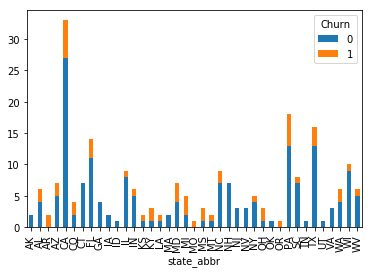

In [77]:
features_df.groupby(["state_abbr", "Churn"])["Churn"].count().unstack().plot(kind="bar", stacked=True)

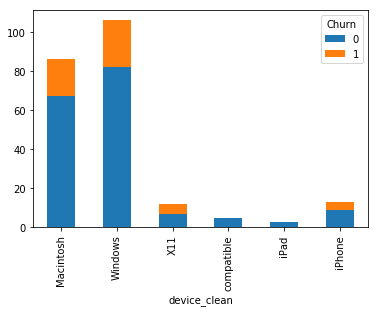

In [78]:
features_df.groupby(["device_clean", "Churn"])["Churn"].count().unstack().plot(kind="bar", stacked=True)

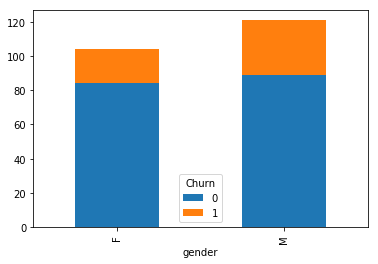

In [79]:
features_df.groupby(["gender", "Churn"])["Churn"].count().unstack().plot(kind="bar", stacked=True)

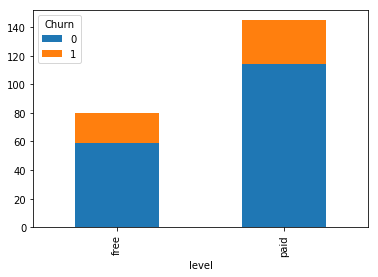

In [80]:
features_df.groupby(["level", "Churn"])["Churn"].count().unstack().plot(kind="bar", stacked=True)

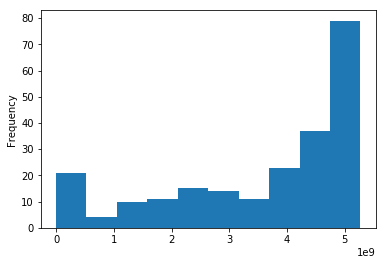

In [82]:
features_df['tenure'].plot.hist()

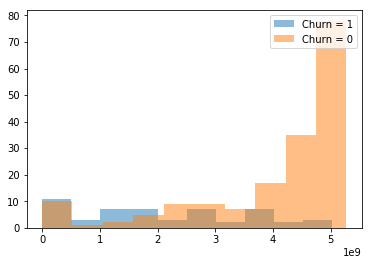

In [90]:
Churn_1 = features_df[(features_df['Churn']==1)]
Churn_0 = features_df[(features_df['Churn']==0)]

pyplot.hist(Churn_1['tenure'], bins=10, alpha=0.5, label='Churn = 1')
pyplot.hist(Churn_0['tenure'], bins=10, alpha=0.5, label='Churn = 0')
pyplot.legend(loc='upper right')
pyplot.show()

In [98]:
features_df.head(10)

,userId,tenure,Churn,firstName,lastName,gender,level,registration,state_abbr,device_clean,f_total_interactions,f_artist_count,f_song_count,f_session_count,p_homepage_lands,p_nextsongs,p_thumbsup,p_thumbsdown,p_addtoplaylist,p_addfriend,p_rolladvert,p_logout,p_downgrade,p_settings,p_help,p_upgrade,p_about,p_savesettings,p_error,p_submitupgrade,p_submitdowngrade,v_http307,v_http400,v_methodput,v_methodget,gender_,state_abbr_,device_clean_,gender_1,gender_2,state0,state1,state2,state3,state4,state5,state6,state7,state8,state9,state10,state11,state12,state13,state14,state15,state16,state17,state18,state19,state20,state21,state22,state23,state24,state25,state26,state27,state28,state29,state30,state31,state32,state33,state34,state35,state36,state37,state38,device0,device1,device2,device3,device4,device5
0,100010,3820418000,0,Darianna,Carpenter,F,free,1538016340000,CT,iPhone,381,252,269,7,11,275,17,5,7,4,52,5,0,0,2,2,1,0,0,0,0,31,0,313,68,0,6,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,200002,3930924000,0,Dominic,Torres,M,paid,1536269906000,WI,iPhone,474,339,378,6,20,387,21,6,8,4,7,5,5,3,2,2,3,0,0,1,0,37,0,432,42,1,37,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,125,1774000,1,Mason,Hart,M,free,1533157139000,TX,Macintosh,11,8,8,1,0,8,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,9,2,1,33,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,124,5183736000,0,Nicole,Beck,F,paid,1532224335000,NJ,Macintosh,4825,2232,3339,29,176,4079,171,41,118,74,4,59,41,20,23,0,7,6,6,0,0,351,0,4548,277,0,24,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,51,1363340000,1,Ethan,Johnson,M,paid,1538080987000,KY,Windows,2464,1385,1854,10,75,2111,100,21,52,28,0,24,23,12,12,0,2,1,1,0,0,175,0,2338,126,1,14,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,7,4387742000,0,Maddox,Johnson,M,free,1536667576000,WA,Windows,201,142,148,7,10,150,7,1,5,1,16,3,0,3,1,2,0,1,1,0,0,13,0,168,33,1,36,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,15,4732403000,0,Panav,Myers,M,paid,1538239045000,WV,Windows,2278,1302,1707,15,93,1914,81,14,59,31,1,27,28,16,8,0,2,2,2,0,0,155,0,2128,150,1,38,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,54,3697678000,1,Alexi,Warren,F,paid,1532482662000,WA,Windows,3437,1744,2414,37,129,2841,163,29,72,33,47,36,39,17,17,1,5,3,1,1,1,267,0,3180,257,0,36,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,155,2231525000,0,Camila,Calderon,F,paid,1541370470000,NH,Windows,1002,643,759,6,30,820,58,3,24,11,8,14,12,5,9,2,2,0,3,1,0,87,0,931,71,0,23,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,100014,3563513000,1,Rodrigo,Carey,M,paid,1535389443000,PA,Windows,310,233,248,6,7,257,17,3,7,6,2,3,3,1,2,0,0,0,0,0,0,30,0,294,16,1,30,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [104]:
scaler = StandardScaler()

features_x= features_df[['tenure', 'f_total_interactions', 'f_artist_count', 'f_song_count', 'f_session_count',\
                       'p_homepage_lands', 'p_nextsongs', 'p_thumbsup', 'p_thumbsdown', 'p_addtoplaylist', \
                       'p_addfriend', 'p_rolladvert', 'p_logout', 'p_downgrade', 'p_settings', 'p_help', \
                       'p_upgrade', 'p_about', 'p_savesettings', 'p_error', 'p_submitupgrade', 'p_submitdowngrade',\
                       'v_http307', 'v_methodput', 'v_methodget' ]]

scaler.fit(features_x)

features_df_pca = scaler.transform(features_x)

In [106]:
features_df_pca.shape

(225, 25)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [107]:
X_train, X_test, y_train, y_test \
= train_test_split(features_df_pca, features_df[['Churn']], test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val \
= train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [109]:
X_train.shape

(135, 25)

In [110]:
X_val.shape

(45, 25)

In [111]:
X_test.shape

(45, 25)

In [115]:
y_train.shape

(135, 1)

In [129]:
#build a logistic regression model
logreg = LogisticRegression()
# Fit the model to our X and y training sets
logreg.fit(X_train, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [130]:
# fit the model with data
y_pred_test=logreg.predict(X_test)

acc_test = metrics.accuracy_score(y_pred_test, y_test)
print("Accuracy: ",acc_test)

f1_test = metrics.f1_score(y_pred_test, y_test)
print("F1: ",f1_test)

Accuracy:  0.844444444444
F1:  0.363636363636


In [126]:
from sklearn.ensemble import RandomForestClassifier
random_classifier= RandomForestClassifier()
random_classifier.fit(X_train,y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [127]:
y_pred_test_rf= random_classifier.predict(X_test)

In [128]:
acc_test_rf = metrics.accuracy_score(y_pred_test_rf, y_test)
print("Accuracy Random Forest: ",acc_test_rf)

f1_test_rf = metrics.f1_score(y_pred_test_rf, y_test)
print("F1 Random Forest: ",f1_test_rf)

Accuracy Random Forest:  0.755555555556
F1 Random Forest:  0.153846153846


The logistic regression model has a higher F1 score, so it is selected as the final model.

In [131]:
y_pred_val=logreg.predict(X_val)

acc_val = metrics.accuracy_score(y_pred_val, y_val)
print("Accuracy Validation: ",acc_val)

f1_val = metrics.f1_score(y_pred_val, y_val)
print("F1 Validation: ",f1_val)

Accuracy Valuation:  0.866666666667
F1 Valuation:  0.785714285714


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.